## How much variance does each pc explain for its cluster's genes?

I'm concerned that pcqtls are being driven by the expression of individual genes. 

Stephen suggests the following: 

"We should plot how much variance is explained by each PCqtl and see if there are some where it is imbalanced across genes or pretty similar. You could do a scatterplot of variance explained for gene 1 and gene 2 where gene 1 and 2 are the genes where the most variance is explained (for multi gene clusters beyond 2) "


qtl variance is the suqared effect size, if the data is standardized. I could also look look at the gene variance explianed by the PC itself

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks
import ast


In [230]:
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

prefix = '/home/klawren/oak/pcqtls'
pcqtl_output_dir = "output/pcqtl_proteincoding"
eqtl_output_dir = "output/control_eqtl_proteincoding"
overlap_output_dir = "output/overlap_proteincoding"
pc_out_dir = "output/pcs_proteincoding"
clusters_dir = "output/clusters_proteincoding_tami"
covariates_dir = "data/processed/covariates_tami"
filtered_expression_output_dir= "data/processed/clusters_proteincoding_expression/"





load in data

In [40]:
# load nominal p value dfs

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [41]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    return pc_nominal_df

pc1_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc1_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_1.cis_qtl_pairs.chr{chr_id}.parquet'))
pc1_nominal_df = pd.concat(pc1_nominal_dfs)


pc2_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc2_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_2.cis_qtl_pairs.chr{chr_id}.parquet'))
pc2_nominal_df = pd.concat(pc2_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [43]:
overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

In [44]:
# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']
pc1_nominal_df['var_cluster'] = pc1_nominal_df['variant_id'] + '_' + pc1_nominal_df['cluster_id']
pc2_nominal_df['var_cluster'] = pc2_nominal_df['variant_id'] + '_' + pc2_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']

# set e_nominal to be index based on variant-cluster pairs
e_nominal_df_cid = e_nominal_df.set_index('var_cluster')


### lead variant only

start with just lead variants from susie (this is not exactly correct but will work for a first pass)

In [45]:
pc1qtl_vars = overlap_df[overlap_df['orig_cs_dataset'] == 'pc_1_qtl']['var_cluster']

In [46]:
# get the eqtl effects for the pcqtl lead variants 
pc1qtl_vars_e_nominal = e_nominal_df_cid.loc[pc1qtl_vars]
pc1qtl_vars_e_nominal.reset_index(inplace=True)
pc1qtl_vars_e_nominal['effect_size'] = pc1qtl_vars_e_nominal['slope']**2

In [47]:
# keep only the largest and 2nd largest effect size for each cluster 
plot_df = pc1qtl_vars_e_nominal.groupby('cluster_id').apply(lambda x: x.nlargest(2, 'effect_size')).reset_index(drop=True)

# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cluster_id')['effect_size'].rank("dense", ascending=False)

# Pivot the DataFrame
plot_df = plot_df.pivot(index='cluster_id', columns='rank', values='effect_size')

# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

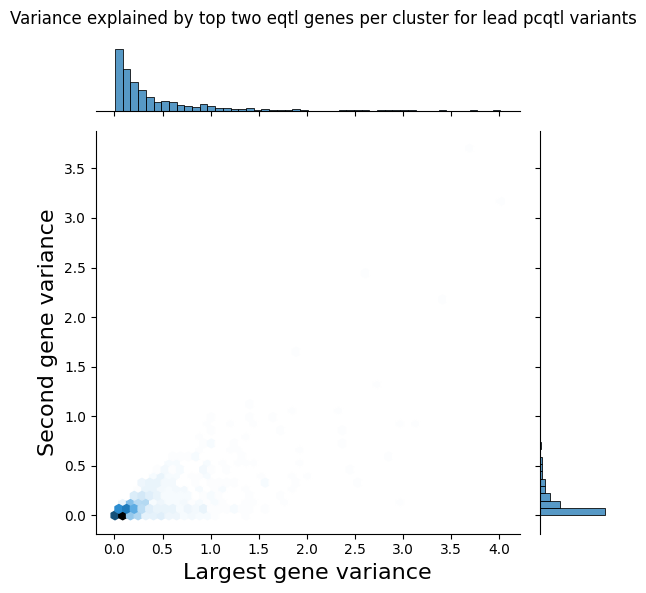

In [55]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


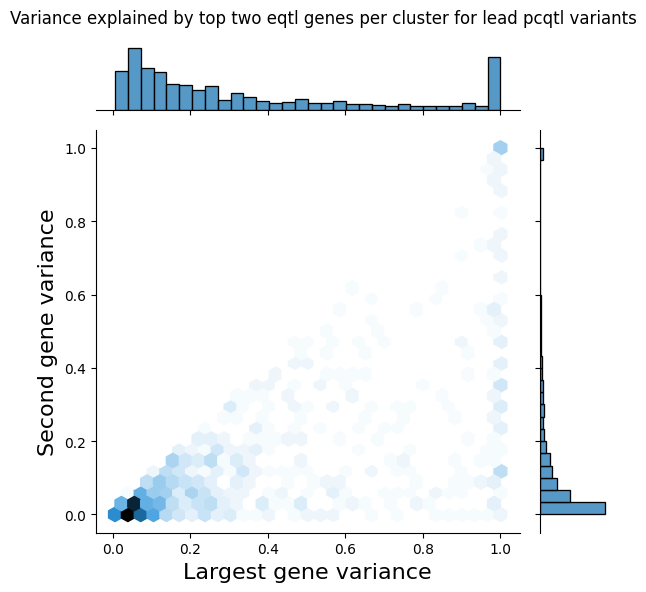

In [53]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df.clip(upper=1), x='largest', y='second_largest', kind='hex', gridsize=30, marginal_kws=dict(bins=30))

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()

### credible set

Rather than just taking the variance of the lead snp, I can expand to take the pip*variance for the whole credible set

In [56]:
# load in the susie df, so I have the pip values for the variants as well as the slopes
pc1_susie_df = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
pc1_susie_df['var_cluster'] = pc1_susie_df['variant_id'] + '_' + pc1_susie_df['phenotype_id'].str.split('_pc1').str[0]
pc1_susie_df['cs_id'] =  pc1_susie_df['phenotype_id'].str.split('_pc1').str[0] + '_' + pc1_susie_df['cs_id'].astype(str)

In [57]:
# pull out the variants that are part of a pc1qtl credible set
pc1qtl_cs_e_nominal = e_nominal_df_cid.loc[pc1_susie_df['var_cluster']]
pc1qtl_cs_e_nominal.reset_index(inplace=True)

# add in the pip, then calculate the effects size as a pip weighted slope**2
pc1qtl_cs_e_nominal['pip'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc1_susie_df.set_index('var_cluster')['pip'])
pc1qtl_cs_e_nominal['variance'] = pc1qtl_cs_e_nominal['slope'].apply(np.square)
pc1qtl_cs_e_nominal['variance_weighted'] = pc1qtl_cs_e_nominal['variance'] * pc1qtl_cs_e_nominal['pip']

In [63]:
# group by credible set 
pc1qtl_cs_e_nominal['cs_id'] = pc1qtl_cs_e_nominal['var_cluster'].map(pc1_susie_df.set_index('var_cluster')['cs_id'])
# get the sum of pip weighted variances for the credible set
plot_df = pd.DataFrame(pc1qtl_cs_e_nominal.groupby(['cs_id', 'egene_id'])['variance_weighted'].sum())
# take just the two largest variances
plot_df = plot_df.groupby('cs_id')['variance_weighted'].nlargest(2)

In [64]:
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)


KeyError: 'Column not found: variance_weighted'

In [ ]:
# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cs_id')['variance_weighted'].rank("dense", ascending=False)
# Pivot the DataFrame
plot_df = plot_df.pivot(index='cs_id', columns='rank', values='effect_size')
# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

In [ ]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex')

# Set labels
jplot.set_axis_labels('Largest gene variance', 'Second gene variance', fontsize=16)

plt.suptitle('Variance explained by top two eqtl genes per cluster for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]. Dan suggests this could be the case if the genotype or expression were not normalized. 

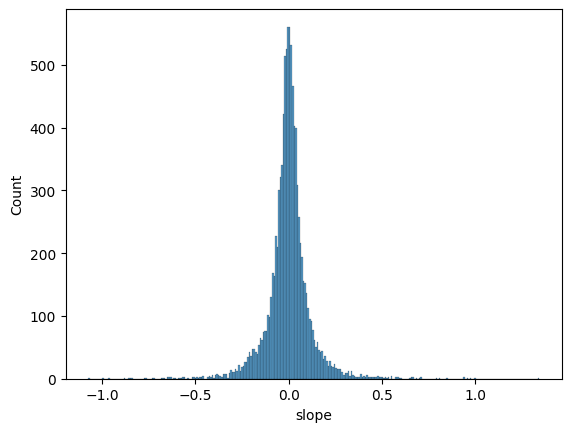

In [51]:
sns.histplot(e_nominal_df.sample(10000), x='slope')
plt.show()

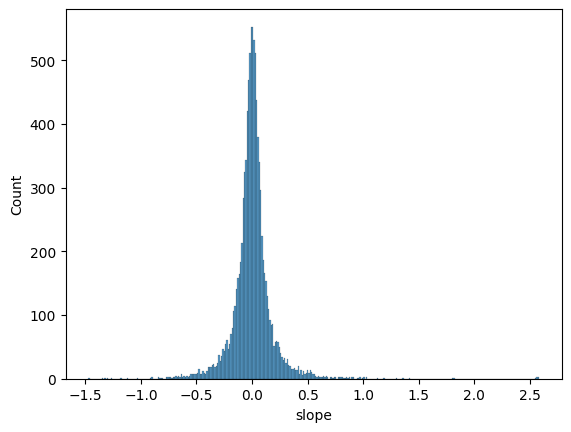

In [59]:
sns.histplot(pc1_nominal_df.sample(10000), x='slope')
plt.show()

### the PCs themselves
do they explain the variance for multiple genes?

In [115]:
import tensorqtl
import torch
from tensorqtl.core import Residualizer
from sklearn.decomposition import PCA


In [76]:
# adapted from tensorqtl
def calculate_residual(phenotype_df, covariates_df, center=False):
    """Calculate normalized residual phenotypes"""
    # set up residualize device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    residualizer = Residualizer(torch.tensor(covariates_df.values, dtype=torch.float32).to(device))
    phenotype_t = torch.tensor(phenotype_df.values, dtype=torch.float).to(device)

    # residualize
    phenotype_res_t = residualizer.transform(phenotype_t)  # phenotypes x samples

    # center and normalize
    if center:
        phenotype_res_t = tensorqtl.core.center_normalize(phenotype_res_t, dim=1)

    return phenotype_res_t.numpy()


def reformat_cluster_df(cluster_df, expression_df_gid, pc_num=1):
    # chromosome in different format
    cluster_df['#chr'] = 'chr' + cluster_df['Chromosome'].astype(str)

    # start and stop
    def get_start(ts):
        return expression_df_gid.loc[ts.split(',')]['start'].min()
    def get_end(ts):
        return expression_df_gid.loc[ts.split(',')]['end'].max()
    cluster_df['start'] = cluster_df['Transcripts'].apply(lambda x: get_start(x))
    cluster_df['end'] = cluster_df['Transcripts'].apply(lambda x: get_end(x))

    # cluster id "gene_id", sorted gene ids with '_' as seperator 
    # sorted so this matches the cluster id generated by the control eqtls
    cluster_df['gene_id'] = ['_'.join([*sorted(t.split(',')), f'pc{pc_num}']) for t in cluster_df['Transcripts']]
    return cluster_df

def get_PC(ts, expression_df_gid, pc_num=1):
    # function to get PCs
    cluster = expression_df_gid.loc[ts.split(',')]
    X = cluster[cluster.columns[3:]].transpose()
    pca = PCA(n_components=pc_num)
    pca.fit(X)
    X_transformed = pca.transform(X)
    return X_transformed[:,pc_num-1]

In [241]:
expression_path = f'{prefix}/{filtered_expression_output_dir}/{tissue_id}.v8.normalized_expression.cluster_genes.bed'
expression_df_new = pd.read_csv(expression_path, sep='\t')



In [244]:
expression_path = '/home/klawren/oak/pcqtls/data/processed/normalized_expression_tami/Cells_Cultured_fibroblasts.v8.normalized_expression.bed'
#f'{prefix}/data/processed/normalized_expression_tami/data/{tissue_id}.v8.normalized_expression.bed'
cluster_path = f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv'
covariates_path = f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt'

In [245]:
cluster_df = pd.read_csv(cluster_path)
cluster_orig_columns = cluster_df.columns.values
expression_df = pd.read_csv(expression_path, sep='\t')
expression_df_gid = expression_df.set_index('gene_id')

covariates_df = pd.read_csv(covariates_path, sep='\t', index_col=0).T

In [255]:
expression_df_new['gene_id_split'] = expression_df_new['gene_id'].str.split('_e_').str[1]
expression_df_gid_new = expression_df_new.set_index('gene_id_split')


In [256]:
expression_df_gid_new

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVE1,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
gene_id_split,,,,,,,,,,,,,,,,,,,,,
ENSG00000187961.13,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.013115,-0.055819,-0.090444,-0.091985,0.004575,-0.013917,...,-0.003722,0.024374,-0.023902,0.066875,0.031793,0.006578,0.130061,0.125158,0.007906,0.001809
ENSG00000187583.10,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.006866,0.003739,-0.040659,-0.036323,-0.034702,-0.085119,...,0.031486,0.004679,-0.053182,0.009170,-0.024076,0.004492,-0.025653,0.021175,-0.055821,-0.024654
ENSG00000248333.8,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.016525,0.010553,-0.047886,0.024311,0.016909,0.014266,...,-0.041838,-0.010725,0.057456,-0.046688,-0.017291,-0.066444,0.003485,-0.001198,0.050554,-0.000734
ENSG00000189339.11,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.021630,-0.023068,-0.004732,0.043878,0.052115,0.000848,...,0.017906,-0.022188,0.023325,-0.004544,-0.114601,-0.035045,-0.003366,-0.044418,0.030785,0.052362
ENSG00000008128.22,chr1,1724323,1745992,ENSG00000008128.22_ENSG00000215790.6_e_ENSG000...,0.022301,-0.006302,0.052893,0.030058,-0.026409,0.009420,...,-0.015872,-0.000023,-0.001885,-0.067950,-0.025478,-0.011199,0.019256,0.051944,-0.050737,0.053034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000054148.17,chr9,136844414,136849091,ENSG00000054148.17_ENSG00000232434.2_e_ENSG000...,0.063705,0.022670,-0.019850,0.026377,-0.019160,-0.004368,...,-0.008556,0.036851,0.049081,0.022671,0.070805,-0.037879,0.042536,-0.066309,0.030523,0.053540
ENSG00000107317.12,chr9,136975091,136982993,ENSG00000107317.12_ENSG00000214402.6_e_ENSG000...,-0.014654,-0.085425,-0.027186,-0.026729,0.025530,-0.032041,...,0.050765,0.084739,0.018532,-0.001237,0.012782,0.037961,0.102727,-0.038826,-0.014448,-0.002191
ENSG00000214402.6,chr9,136975091,136982993,ENSG00000107317.12_ENSG00000214402.6_e_ENSG000...,0.016507,-0.013625,-0.091028,-0.007401,0.070575,0.005147,...,0.008976,0.094239,-0.034723,0.010009,-0.016288,0.026199,0.072535,0.036085,-0.060743,0.004901


In [ ]:
# add .bed info to cluster
cluster_df = reformat_cluster_df(cluster_df, expression_df_gid_new, pc_num=1)

In [112]:
# residualize expression 
residal_exp = calculate_residual(expression_df[expression_df.columns[4:]], covariates_df)
expression_df_res = expression_df_gid.copy()
expression_df_res[expression_df.columns[4:]] = residal_exp

In [197]:
pc_values

array([[-1.4423395 ,  0.08754167, -0.3542062 ,  0.18143374, -0.33051232,
         0.18430156],
       [ 0.49165356, -0.38090584, -0.2676274 ,  0.6862264 ,  0.2250392 ,
        -0.59505004],
       [ 0.18755051, -0.21534708,  0.06078588, -0.3980165 , -0.1013087 ,
         0.35193446],
       ...,
       [ 1.7535158 ,  0.7449167 , -0.3559264 ,  0.222226  ,  0.05437247,
         0.29316288],
       [-0.79441154,  0.514335  , -0.71319836, -0.2751357 , -0.21594708,
         0.23556598],
       [-1.7542151 , -0.2690325 ,  0.94515073,  0.37759215, -0.16322482,
        -0.4414246 ]], dtype=float32)

In [207]:
normed_residualized_pcs = calculate_residual(pd.DataFrame(pc_values.T, columns = expression_df.columns[4:]), covariates_df, center=True)

In [223]:
cluster_df = cluster_df.sample(10)

In [224]:
cluster_pcs_dfs = []
for idx, row in tqdm(cluster_df.iterrows(), total=cluster_df.shape[0]):

    # get all pcs and combine 
    cluster = expression_df_res.loc[row['Transcripts'].split(',')]
    X = cluster[cluster.columns[3:]].transpose()
    pca = PCA()
    pc_values = pca.fit_transform(X)

    # get an id for each pc
    gene_ids = []
    for pc_num in range(pc_values.shape[1]):
        print()
        gene_ids.append('_'.join([*sorted(row['Transcripts'].split(',')), f'pc{pc_num+1}']))

    # center normalized and residualize the pcs
    normed_residualized_pcs = calculate_residual(pd.DataFrame(pc_values.T, columns = expression_df.columns[4:]), covariates_df, center=True)

    # make a dataframe of the pcs for this cluster
    cluster_pcs_df = pd.DataFrame(normed_residualized_pcs, 
                columns = expression_df.columns[4:], 
                index = gene_ids)


    # make the gene id index a column
    cluster_pcs_df =cluster_pcs_df.reset_index().rename(columns={'index': 'gene_id'})
    # add the other information needed for a bed file
    cluster_pcs_df['start'] = row['start']
    cluster_pcs_df['end'] = row['end']
    cluster_pcs_df['#chr'] = row['#chr']

    # make the right order for bed
    cluster_pcs_dfs.append(make_bed_order(cluster_pcs_df))


  0%|          | 0/10 [00:00<?, ?it/s]

In [225]:
cluster

,#chr,start,end,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZVE1,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000197457.9,chr20,63657681,63657682,-0.011057,-0.279032,-0.064873,-0.007313,0.545415,-0.422475,0.271828,...,-0.812662,-0.672050,-0.473292,-0.029439,0.468790,-0.085787,-0.862881,-0.259710,0.025726,-0.805793
ENSG00000258366.7,chr20,63657809,63657810,0.006766,0.180802,-0.097460,0.171198,0.498942,-0.198752,0.070314,...,-0.182214,-0.076948,-0.156726,-0.212546,0.114898,-0.055425,-0.243000,0.104540,-0.582018,-0.439274
ENSG00000243509.4,chr20,63696667,63696668,-0.062148,0.572465,0.530069,-1.020961,0.199020,-0.120080,0.545786,...,0.449843,-0.126642,-0.313114,-0.241558,0.012415,-0.535855,-0.097588,-0.339395,-0.076009,-0.269601


In [229]:
pca.components_[:,0]

array([ 0.86652523, -0.47861582, -0.14163576], dtype=float32)

In [211]:
def make_bed_order(df):
    # the column order matters, so rearrange columns
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('#chr')))
    cols.insert(1, cols.pop(cols.index('start')))
    cols.insert(2, cols.pop(cols.index('end')))
    cols.insert(3, cols.pop(cols.index('gene_id')))
    df = df.loc[:, cols]
    # sort positions
    df.sort_values(['start'], inplace=True)
    return df

In [212]:
make_bed_order(cluster_pcs_df)

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVE1,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
0,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,-0.072102,0.024577,0.009375,0.030836,0.091613,0.000519,...,0.073691,0.059314,0.016700,0.005661,-0.005199,0.080904,0.069284,0.087657,-0.039712,-0.087692
1,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,0.006792,-0.029552,-0.016707,-0.086523,0.027577,0.046615,...,0.028441,-0.018255,0.056483,0.054228,0.037368,-0.010223,0.072057,0.057793,0.039904,-0.020873
2,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,-0.033394,-0.025231,0.005731,-0.003899,0.009882,-0.012344,...,0.003391,0.015556,0.032931,-0.023053,0.037005,-0.003664,-0.010896,-0.033556,-0.067239,0.089107
3,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,0.018179,0.068758,-0.039880,-0.042216,0.008405,0.043952,...,0.066032,-0.011400,0.053499,0.004045,0.083752,-0.028163,0.035375,0.022266,-0.027568,0.037834
4,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,-0.041683,0.028381,-0.012777,-0.068278,0.023730,-0.032822,...,0.078858,0.005700,-0.016986,0.053421,0.002419,-0.024601,0.036782,0.006857,-0.027235,-0.020585
5,chr1,152908544,153057537,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,0.026687,-0.086164,0.050960,-0.002888,0.052375,-0.014046,...,-0.025232,-0.054942,0.042765,0.061006,0.010985,0.001310,0.012298,0.042450,0.034110,-0.063919


In [152]:
g_id = cluster_df['gene_id'].iloc[0]

In [168]:
gene_ids

['ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc1',
 'ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc2',
 'ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc3',
 'ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc4',
 'ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc5',
 'ENSG00000163207.6_ENSG00000163209.14_ENSG00000163216.6_ENSG00000169469.8_ENSG00000169474.4_ENSG00000241794.1_pc6']

In [150]:
pcs = 
for idx, row in cluster_df.sample(10).iterrows():
    cluster = expression_df_gid.loc[row['Transcripts'].split(',')]
    X = cluster[cluster.columns[3:]].transpose()
    pca = PCA()
    out = pca.fit_transform(X)

array([[ 0.17373317, -0.14214251,  0.33513037, -0.37492553,  0.36960217,
         0.2598722 ],
       [-0.36534907, -0.41779271,  0.06295349, -0.63543332, -0.07569757,
        -0.36025717],
       [-0.75564364, -0.39243137,  0.03834947,  0.08193392, -0.00586591,
         0.32224425],
       ...,
       [ 1.73391631, -0.57185898, -0.27290619, -0.81578927, -0.16308907,
        -0.20697682],
       [-0.23295301, -0.11136964,  0.72854849,  0.21573044,  0.17522505,
         0.21575378],
       [-0.65911476, -0.61013951, -0.82584573,  0.43745052,  0.160252  ,
        -0.3097692 ]])

In [148]:
pcs = cluster_df['Transcripts'].apply(lambda x: get_PC(x, expression_df_res, pc_num=1))


In [132]:
expression_df[expression_df.columns[4:]]

,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-1192X,...,GTEX-ZVE1,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
0,-1.175813,-0.617068,-1.648873,-0.409983,0.892918,0.432622,0.472789,0.041444,0.519653,-0.513734,...,-0.561612,-1.690622,0.213960,-0.847540,-0.832798,0.579898,-0.393142,-0.015538,-1.712650,-0.387553
1,1.629034,0.166494,-1.505361,0.537519,0.135063,-0.854980,1.125610,0.267277,0.908458,0.283414,...,-0.166494,0.674490,0.219262,-1.207414,-0.818235,0.940215,-1.609816,0.129838,0.789616,0.299626
2,-0.182269,-2.083671,-1.240269,-0.870005,-1.322654,-0.579898,-0.161245,-0.129838,1.145345,-0.513734,...,-0.267277,-0.998201,-0.948303,-1.415149,0.245867,-0.208664,-1.360873,-1.629034,-0.072569,0.415623
3,-2.500646,-0.387553,-1.145345,-1.262938,-0.432622,-0.261913,-0.761630,-0.108974,-0.161245,-0.519653,...,1.087401,-0.642327,0.714033,0.166494,0.432622,-0.208664,-0.714033,-1.609816,-1.286275,1.196748
4,-0.156000,1.024106,-1.896823,-0.573781,0.421276,1.759383,0.543513,-1.929095,0.592197,1.115905,...,0.310477,0.278027,-0.674490,-0.818235,1.096804,-0.272648,-1.106304,0.478588,-0.885229,0.376411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22045,-1.443924,-1.443924,0.964669,-0.501950,1.759383,0.687551,-0.555559,1.251523,-0.114185,-1.443924,...,-0.343257,0.278027,0.734228,0.398743,2.000424,1.322654,-0.182269,-0.537519,-0.283414,0.203374
22046,0.501950,0.832798,0.932187,0.245867,-0.224570,0.156000,0.198089,-0.031079,0.409983,1.175813,...,0.707366,2.244607,0.256557,-0.484404,-0.051813,0.455485,0.775547,-0.370857,1.866414,0.051813
22047,-0.916310,2.867887,-2.040281,0.305047,0.421276,-2.000424,-0.885229,0.046628,0.337769,1.196748,...,-0.229884,0.964669,-0.135063,-1.591175,-0.490236,1.068880,0.310477,-0.119400,0.299626,-0.531545
22048,0.398743,-0.387553,0.648705,-0.046628,0.472789,0.229884,0.444025,0.315916,0.908458,0.573781,...,0.892918,0.119400,1.347914,0.467006,-0.579898,0.840146,1.360873,1.335178,0.747859,0.727463


In [146]:
np.stack(pcs.tolist()).shape

(999, 483)

In [133]:
pc_df = pd.DataFrame(np.stack(pcs.tolist()), 
                         columns = expression_df.columns[4:], 
                         index = cluster_df.index)

In [130]:
residal_pcs = calculate_residual(pcs, covariates_df, center=True)
    # expression_df_res = expression_df_gid.copy()
    # expression_df_res[expression_df.columns[4:]] = residal_exp

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [121]:
cluster = expression_df_gid.loc[ts.split(',')]
X = cluster[cluster.columns[3:]].transpose()

In [123]:
pca = PCA()
out = pca.fit_transform(X)

In [125]:
out.shape

(483, 6)

In [128]:
tensorqtl.core.center_normalize(out, dim=1)

TypeError: _mean() got an unexpected keyword argument 'dim'

In [78]:
pc_df = pd.read_csv(f'{prefix}/{pc_out_dir}/{tissue_id}.pc_1.bed', sep='\t')

In [93]:
pc_df[pc_df.columns[4:]].iloc[60]

GTEX-111VG    0.114924
GTEX-111YS    0.197242
GTEX-1122O   -0.059496
GTEX-1128S   -0.224604
GTEX-113IC   -0.069054
                ...   
GTEX-ZVT4    -0.126471
GTEX-ZVZP     0.091532
GTEX-ZVZQ     0.004565
GTEX-ZXES    -0.144618
GTEX-ZXG5     0.042320
Name: 60, Length: 483, dtype: float64

<Axes: xlabel='100', ylabel='Count'>

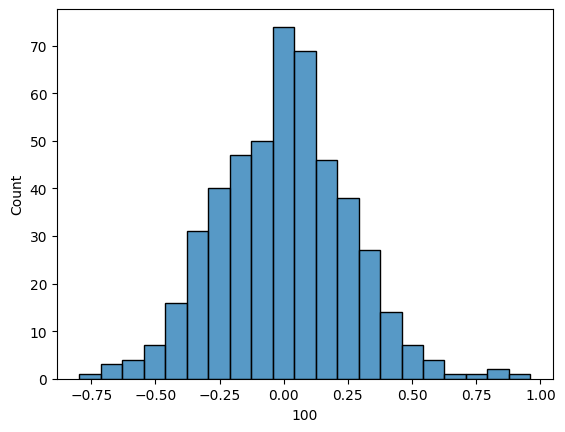

In [94]:
sns.histplot(pc_df[pc_df.columns[4:]].iloc[100])